# Training Model MERA
<a id="0"></a> <br>
1. [Data Preparation](#1)
2. [Model](#2)
3. [Training](#3)
4. [Accuracy](#4)

<a id="1"></a>
### Data Preparation

In [8]:
from Modules.ImageLoader import ImageLoader
loader = ImageLoader('./Data_Sources/al5083/train', './Data_Sources/al5083/train/train.json', (64, 64))
all_data = loader.load_images(image_limit=100,vertical_start_split=0.3, vertical_end_split=1.0,
                              horizontal_start_split=0.25, horizontal_end_split=0.75)

Shuffles the dataset and separates it into flattened features and labels.

In [9]:
import Modules.Utils
X_set,Y_set = Modules.Utils.prepare_data(all_data)

In [10]:
X_reduced = Modules.Utils.apply_pca(X_set, n_components=256)

Split train data to train set and validation set.

In [11]:
X_train, Y_train, X_val, Y_val = Modules.Utils.split_data(X_reduced, Y_set, train_ratio=0.8)

Training set:

In [12]:
import numpy as np
values, counts = np.unique(Y_train, return_counts=True)
print(values)
print(counts)

[0 1 2 3 4 5]
[75 82 75 83 84 81]


Validation set:

In [13]:
import numpy as np
values, counts = np.unique(Y_val, return_counts=True)
print(values)
print(counts)

[0 1 2 3 4 5]
[25 18 25 17 16 19]


<a id="2"></a>
### Model

Block looks like
![circuit](./Images/MERA_block_1.png)

(<Figure size 1400x300 with 1 Axes>, <Axes: >)

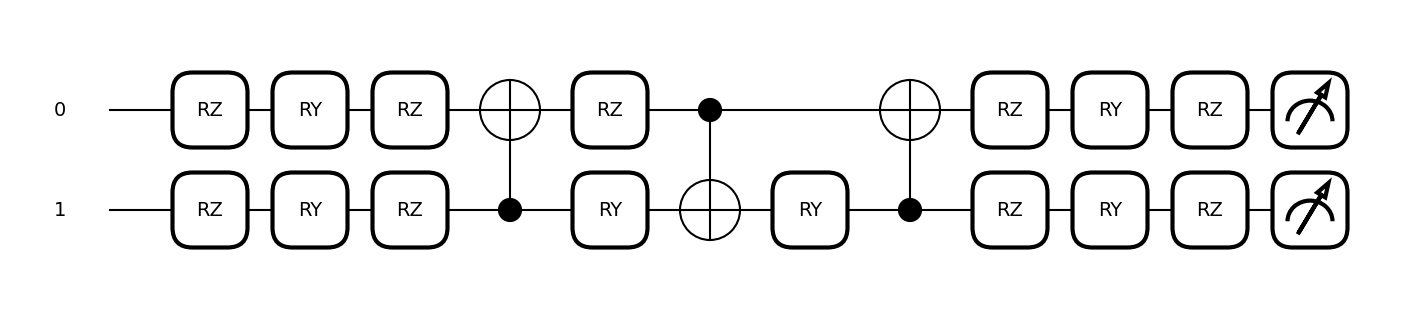

In [14]:
import pennylane as qml
from pennylane import numpy as np
def block(weights, wires):
    qml.RZ(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[0])
    qml.RZ(weights[2], wires=wires[0])

    qml.RZ(weights[3], wires=wires[1])
    qml.RY(weights[4], wires=wires[1])
    qml.RZ(weights[5], wires=wires[1])

    qml.CNOT(wires=[wires[1], wires[0]])

    qml.RZ(weights[6], wires=wires[0])
    qml.RY(weights[7], wires=wires[1])

    qml.CNOT(wires=[wires[0], wires[1]])

    qml.RY(weights[8], wires=wires[1])

    qml.CNOT(wires=[wires[1], wires[0]])

    qml.RZ(weights[9], wires=wires[0])
    qml.RY(weights[10], wires=wires[0])
    qml.RZ(weights[11], wires=wires[0])

    qml.RZ(weights[12], wires=wires[1])
    qml.RY(weights[13], wires=wires[1])
    qml.RZ(weights[14], wires=wires[1])

dev= qml.device('default.qubit',wires=range(2))
@qml.qnode(dev)
def circuit_block(f, template_weights):
    block(template_weights,wires=[0,1])
    return qml.probs(wires = [0, 1])

weights = np.random.random(size=[15, 1])
qml.draw_mpl(circuit_block, expansion_strategy="device")(X_train[0][0:4], weights)

MERA architecture looks like:

![Mera circuit](./Images/MERA_1.png)

(<Figure size 9600x900 with 1 Axes>, <Axes: >)

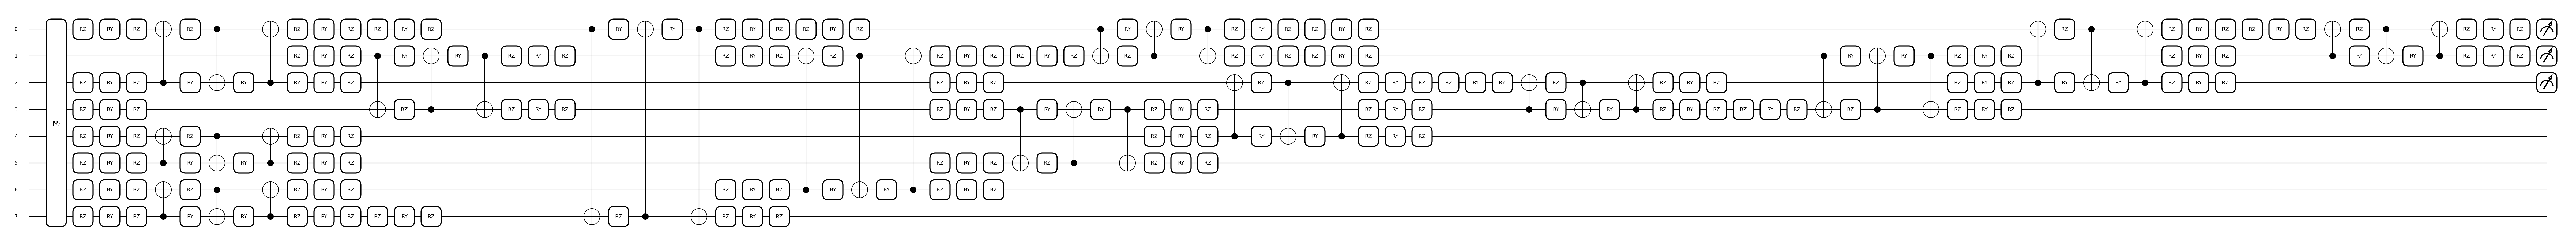

In [15]:
n_wires = 8
n_block_wires = 2
n_params_block = 15
n_blocks = qml.MERA.get_n_blocks(range(n_wires),n_block_wires)
template_weights = [[0.1,-0.3]]*n_blocks


dev= qml.device('default.qubit',wires=range(n_wires))
@qml.qnode(dev)
def circuit_MERA(f, template_weights):
    qml.AmplitudeEmbedding(features=f, wires=range(8), normalize=True)
    qml.MERA(range(n_wires),n_block_wires,block, n_params_block, template_weights)
    return qml.probs(wires = [0, 1, 2])


weights = np.random.random(size=[13, 15])
qml.draw_mpl(circuit_MERA, expansion_strategy="device")(X_train[0], weights)

<a id="3"></a>
### Training
Cost function with Cross-Entropy Loss

In [16]:
import math
def costfunc(params):
    cost = 0
    y_true = [np.array([1, 0, 0, 0, 0, 0, 0, 0]), np.array([0, 1, 0, 0, 0, 0, 0, 0]), np.array([0, 0, 1, 0, 0, 0, 0, 0]), np.array([0, 0, 0, 1, 0, 0, 0, 0]), np.array([0, 0, 0, 0, 1, 0, 0, 0]), np.array([0, 0, 0, 0, 0, 1, 0, 0])]
    len_X_train = len(X_train)
    for i in range(len_X_train):
        prob = circuit_MERA(X_train[i], params)#[0][0:6]

        if Y_train[i] == 0:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[0].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 1:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[1].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 2:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[2].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 3:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[3].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 4:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[4].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 5:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[5].astype(float)*np.log(prob.astype(float))))
    return cost

training the circuit parameters

In [20]:
# training the circuit parameters
x2 = np.random.random(size=[13, 15], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.1)
all_params = []
all_cost = []

for k in range(20):
    params,cost = optimizer.step_and_cost(costfunc, params)
    print(f"Step {k}, cost: {cost}")

    all_cost.append(cost)
    all_params.append(params)
print(params)

Step 0, cost: 2.1257785900507775
Step 1, cost: 1.9209574373300324
Step 2, cost: 1.7888849183820998
Step 3, cost: 1.7415797562521744
Step 4, cost: 1.6652841360777275
Step 5, cost: 1.5759427111621997
Step 6, cost: 1.5422769670914211
Step 7, cost: 1.502733771859192
Step 8, cost: 1.4398950077523127
Step 9, cost: 1.3818301581045949
Step 10, cost: 1.3706868079616377
Step 11, cost: 1.364331152258484
Step 12, cost: 1.3293692542333768
Step 13, cost: 1.3002895750809158
Step 14, cost: 1.276457302657617
Step 15, cost: 1.2461477616698502
Step 16, cost: 1.2267055365134507
Step 17, cost: 1.2043078236032632
Step 18, cost: 1.174944854344848
Step 19, cost: 1.1571570891530285
[[ 0.9118563  -0.07790843  0.29468644  0.51075742  1.24653365  1.00462794
   0.59915185  0.95402419 -0.21074729  1.5627942  -0.73142983  1.42607276
   0.6422916   0.78841342 -0.17634687]
 [ 0.11396542  0.85613989  0.1353352   0.0385277   0.13829466  0.37572158
   0.26170546  0.6025316  -0.21571072  0.52043622  0.11850167  0.46519347

<a id="4"></a>
### Accuracy

In [22]:
x = circuit_MERA(X_val[0], params)
np.argmax(x)

4

In [23]:
Y_val[0]

1

Accuracy every step:

In [26]:
accuracy = []
for index,param in enumerate(all_params):
    test_correct = 0
    for img, true_label in zip(X_val, Y_val):
            # Get predictions from the quantum circuit
            predictions = circuit_MERA(img, param)
            predicted_label = np.argmax(predictions)

            # Increment correct count if prediction matches the true label
            if predicted_label == true_label:
                test_correct += 1
            else:
                test_correct+=0
    # Calculate and print the testing accuracy percentage
    accuracy_value = 100 * test_correct / len(X_val)
    accuracy.append(accuracy_value)
    print(f"Step: {index} Testing accuracy: {accuracy_value:.2f}%")

Step: 0 Testing accuracy: 25.00%
Step: 1 Testing accuracy: 22.50%
Step: 2 Testing accuracy: 32.50%
Step: 3 Testing accuracy: 38.33%
Step: 4 Testing accuracy: 42.50%
Step: 5 Testing accuracy: 51.67%
Step: 6 Testing accuracy: 49.17%
Step: 7 Testing accuracy: 57.50%
Step: 8 Testing accuracy: 57.50%
Step: 9 Testing accuracy: 56.67%
Step: 10 Testing accuracy: 49.17%
Step: 11 Testing accuracy: 47.50%
Step: 12 Testing accuracy: 50.83%
Step: 13 Testing accuracy: 56.67%
Step: 14 Testing accuracy: 64.17%
Step: 15 Testing accuracy: 71.67%
Step: 16 Testing accuracy: 71.67%
Step: 17 Testing accuracy: 68.33%
Step: 18 Testing accuracy: 62.50%
Step: 19 Testing accuracy: 60.83%


In [28]:
prev_params = [[-0.9530112,
  -0.98906303,
  0.42733051,
  -1.39805571,
  1.01886701,
  -0.68204132,
  0.00514752,
  -0.39323435,
  -0.34661737,
  -0.15687394,
  -0.1243168,
  0.77717893,
  1.18312781,
  1.15403932,
  1.16466961],
 [0.80249022,
  1.01692314,
  1.06860298,
  1.08279611,
  0.77524834,
  1.1321046,
  -0.07193343,
  -0.17959468,
  -0.48267898,
  0.06665782,
  0.67104231,
  0.49973432,
  -0.12404609,
  0.86781928,
  0.40445942],
 [-0.75645955,
  -0.0053903,
  -0.66978107,
  2.06982084,
  0.59470875,
  -0.48286915,
  0.22855502,
  -0.25608964,
  0.26474728,
  0.73193011,
  0.49324567,
  0.55765622,
  0.52437025,
  1.15343213,
  0.98389541],
 [0.24554602,
  0.85305715,
  -0.40320187,
  0.19700866,
  0.68200049,
  0.43184852,
  -0.21888523,
  0.40491311,
  0.39699663,
  0.98302689,
  0.73918223,
  0.49543331,
  0.67744069,
  0.0997064,
  0.24062384],
 [-0.18011014,
  0.38552509,
  1.50799571,
  0.4354709,
  -0.00871326,
  0.61847055,
  0.02746425,
  0.00574521,
  0.02958498,
  0.95501015,
  0.27070959,
  0.91249891,
  0.95249745,
  -0.17831894,
  0.22619901],
 [0.20518233,
  0.81643748,
  1.16109525,
  0.13947864,
  0.1759424,
  0.48322843,
  0.06846418,
  -0.0950378,
  0.00775896,
  0.65902638,
  0.23462393,
  0.39093668,
  0.08509386,
  0.98992613,
  0.85199555],
 [0.77239902,
  0.09081079,
  1.17544122,
  0.30483341,
  0.47252682,
  0.30888317,
  -0.05042905,
  -0.0262627,
  -0.05433818,
  0.99253851,
  0.46545735,
  0.41793626,
  0.56937818,
  0.14170485,
  0.11561279],
 [0.35918216,
  2.01954436,
  1.15749464,
  0.07892378,
  1.06284199,
  0.3864667,
  -0.04734854,
  0.02276969,
  -0.02285212,
  0.08301159,
  0.34793749,
  0.07095964,
  0.84712581,
  0.22959024,
  0.1896121],
 [0.12569621,
  0.53454225,
  0.50666257,
  0.93576658,
  0.17216984,
  0.69693813,
  1.13409803,
  0.32713106,
  1.01377522,
  1.05186355,
  -0.32821226,
  0.0977,
  0.6258371,
  0.22018898,
  1.08005685],
 [-0.0100126,
  -0.09907443,
  0.48498914,
  0.83268218,
  0.28325635,
  0.62095775,
  0.84411684,
  0.00764153,
  1.23426695,
  0.94412227,
  0.94081237,
  0.49177658,
  0.90630541,
  -0.15067647,
  0.35894773],
 [-0.07843088,
  0.07197665,
  0.6627734,
  0.78265344,
  -0.10931271,
  0.39993347,
  -0.19598074,
  1.41178989,
  -0.02180733,
  0.71947254,
  0.15630852,
  0.5409152,
  -0.01384568,
  0.33220087,
  0.62506172],
 [0.51556907,
  -0.39206942,
  0.81944355,
  0.60962884,
  0.27574746,
  0.47456692,
  0.29510471,
  0.80594626,
  -0.14338052,
  1.05187637,
  0.81016813,
  0.42732076,
  1.20375165,
  0.63095784,
  0.21430133],
 [-0.16186991,
  1.03534421,
  -0.08678343,
  0.43623868,
  -0.6888566,
  -0.50153466,
  0.95345212,
  -0.24027422,
  -0.97635143,
  0.51137802,
  1.32110903,
  0.80111533,
  0.07833146,
  0.49952233,
  0.33519073]]

In [29]:
test_correct = 0

for img, true_label in zip(X_val, Y_val):
    # Get predictions from the quantum circuit
    predictions = circuit_MERA(img, prev_params)

    # Determine the predicted label
    predicted_label = np.argmax(predictions)

    # Increment correct count if prediction matches the true label
    if predicted_label == true_label:
        test_correct += 1

# Calculate and print the testing accuracy percentage
accuracy = 100 * test_correct / len(Y_val)
print(f"Testing accuracy: {accuracy:.2f}%")

Testing accuracy: 74.17%
